# Summary:
This notebook will cover generating dataframes to set up connections among oncologist, cancer type, abstract id (pmid).

# Table of contents
* [1. get pmid list for each cancertype -- cancer2pmid_dict](#Part1_link)
* [2. get doctor list for each cancertype -- cancer2doctor_dict](#Part2_link)
* [3. get doctor for pmid -- pmid2doctor_dict](#Part3_link)
* [4. get cancer for pmid -- pmid2cancer_dict](#Part4_link)
* [5. get cancer for doctor -- doctor2cancer_dict](#Part5_link)
* [6. get pmid for doctor -- doctor2pmid_dict](#Part6_link)

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import defaultdict
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from ast import literal_eval

<a id='Part1_link'></a>
# 1. get pmid list for each cancertype -- cancer2pmid_dict

In [3]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_catalog=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')

In [4]:
## get_pmid_for_cancertype for top 29 cancertypes
def get_pmid_for_cancertype(cancer_type,data=abstract_catalog):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df=data[data[cancer_type]==1]
    return list(np.array(subset_df.index))

In [5]:
cancertype_flattened_df=pd.read_csv(os.path.join(base_dir, "data/cancertype_df2.csv"))
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)

In [6]:
cancer2pmid_dict=dict()
for cancer_type in cancer_types[:29]:
    cancer2pmid_dict[cancer_type]=get_pmid_for_cancertype(cancer_type)

In [373]:
## get_pmid_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    cancer2pmid_dict[cancer_type]=list(pmid_temp)

In [ ]:
pickle.dump(cancer2pmid_dict, open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"), "wb"))

In [376]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

<a id='Part2_link'></a>
# 2. get doctor list for each cancertype -- cancer2doctor_dict

In [378]:
## get_doctor_for_cancertype for top 28 cancertypes
def get_doctor_for_cancertype(cancer_type):
    cancer_pmid=get_pmid_for_cancertype(cancer_type,data=abstract_catalog)
    doctor_list=[]
    for pmid in cancer_pmid:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    return list(set(doctor_list))

In [380]:
cancer2doctor_dict=dict()

In [381]:
for cancer_type in cancer_types[:29]:
    cancer2doctor_dict[cancer_type]=get_doctor_for_cancertype(cancer_type)

In [383]:
## get_doctor_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    doctor_list = []
    for pmid in pmid_temp:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    cancer2doctor_dict[cancer_type]=list(set(doctor_list))  

In [388]:
cancer2doctor_dict_counts=[len(cancer2doctor_dict[i]) for i in cancer2doctor_dict]

In [389]:
print(max(cancer2doctor_dict_counts))
print(min(cancer2doctor_dict_counts))

799
21


In [390]:
cancer2doctor_counts_df=pd.DataFrame({'cancer_type':list(cancer2doctor_dict.keys()), 'counts':cancer2doctor_dict_counts})
cancer2doctor_counts_df.head()

,cancer_type,counts
0,Breast Cancer,799
1,Lung Cancer,777
2,Leukemia,537
3,Prostate Cancer,490
4,Colorectal Cancer,588


Text(0.5, 1.0, 'Number of oncologists for each cancer type')

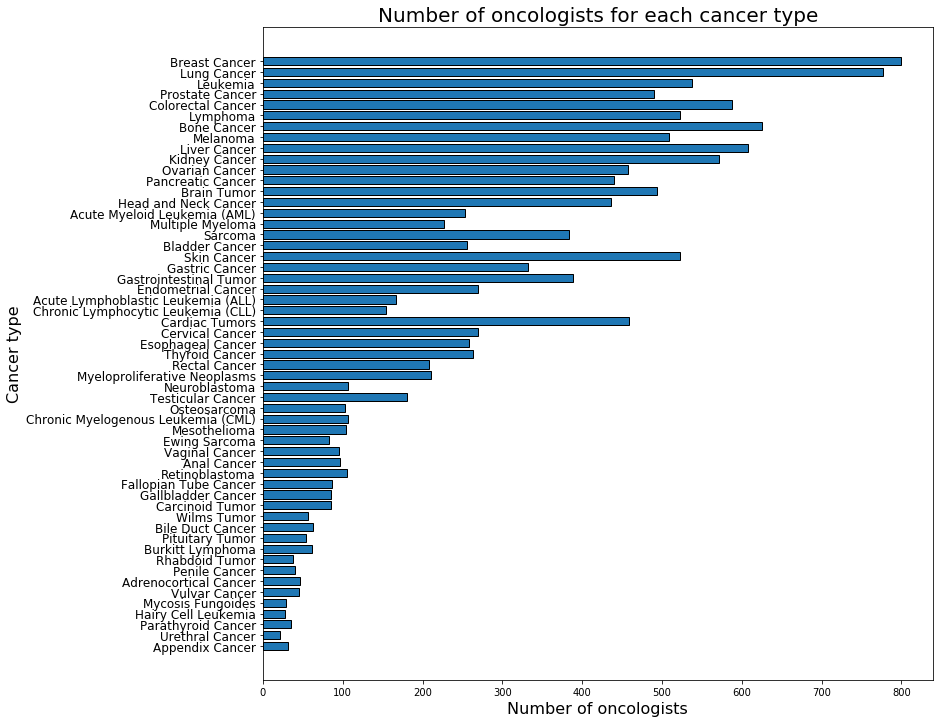

In [391]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(cancer2doctor_counts_df))  # the x locations for the groups
ax.barh(ind, cancer2doctor_counts_df.counts, width, edgecolor='black')
ax.invert_yaxis()
plt.yticks(ind, labels = cancer2doctor_counts_df.cancer_type, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('Number of oncologists', fontsize=16)
plt.title('Number of oncologists for each cancer type', fontsize=20)

<a id='Part3_link'></a>
# 3. get doctor for pmid -- pmid2doctor_dict

In [183]:
pmid2doctor_dict = defaultdict(list)

In [184]:
oncologist_speciality_pmid_df=pickle.load(open(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.pkl"),"rb"))

In [196]:
for pmid in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [445]:
pmid2doctor_dict_df = pd.DataFrame.from_dict(pmid2doctor_dict,orient='index')
pmid2doctor_dict_df['doctor'] = pmid2doctor_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
pmid2doctor_dict_df = pmid2doctor_dict_df.loc[:,'doctor'].to_frame()
pmid2doctor_dict_df.head()

,doctor
10079468,[Hagop M. Kantarjian]
10581602,[Kenneth J. Pienta]
11719088,[James L. Abbruzzese]
11719506,[David Walterhouse]
11719516,[Karen E. Knudsen]


In [446]:
pmid2doctor_dict_df.to_csv(os.path.join(base_dir, 'data/pmid2doctor_dict_df.csv'),index=True,index_label='pmid')

In [214]:
pmid2doctor_counts_df = pd.DataFrame.from_dict(Counter(pmid2doctor_dict_counts), orient='index').rename(columns={0:'counts'})
pmid2doctor_counts_df.head()

,counts
1,36913
2,8671
3,3132
4,1286
6,210


Text(0.5, 1.0, 'Number of oncologists for each abstract')

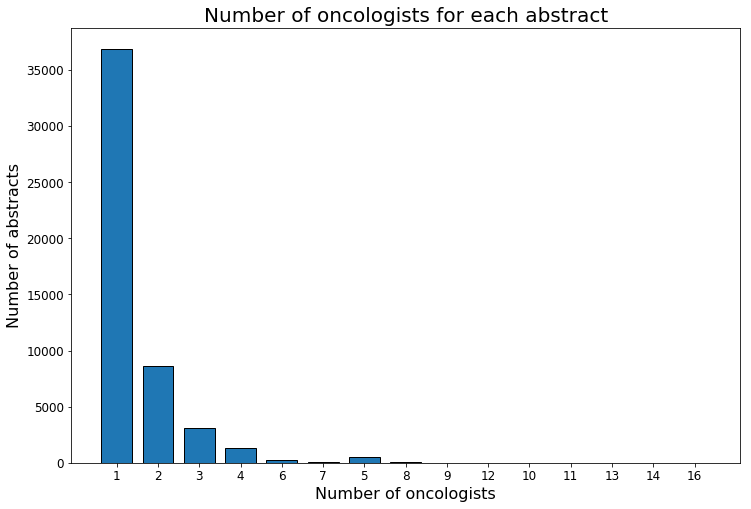

In [294]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(pmid2doctor_dict_counter))  # the x locations for the groups
ax.bar(ind, pmid2doctor_counts_df.counts, width, edgecolor='black')
plt.xticks(ind, labels = pmid2doctor_counts_df.index, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)]
plt.xlabel('Number of oncologists', fontsize=16)
plt.ylabel('Number of abstracts', fontsize=16)
plt.title('Number of oncologists for each abstract', fontsize=20)

Text(0.5, 0, 'Number of oncologists')

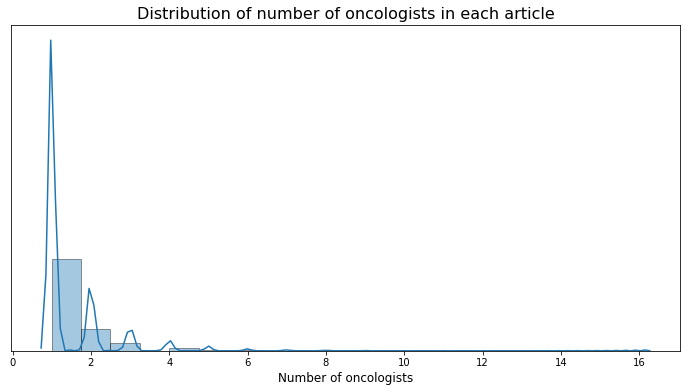

In [298]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(pmid2doctor_dict_counts,hist=True,bins=20,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of oncologists in each article',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of oncologists',fontsize=12)

<a id='Part4_link'></a>
# 4. get cancer for pmid -- pmid2cancer_dict

In [394]:
pmid2cancer_dict=dict()

In [395]:
for doctor in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [397]:
pickle.dump(pmid2cancer_dict, open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"), "wb"))

In [449]:
pmid2cancer_dict=pickle.load(open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"),"rb"))

<a id='Part5_link'></a>
# 5. get cancer for doctor -- doctor2cancer_dict

In [400]:
doctor2cancer_dict=defaultdict(list)

In [401]:
for cancer in cancer2doctor_dict:
    for doctor in cancer2doctor_dict[cancer]:
        doctor2cancer_dict[doctor].append(cancer)

In [402]:
len(doctor2cancer_dict)

1129

In [438]:
doctor2cancer_dict_df = pd.DataFrame.from_dict(doctor2cancer_dict,orient='index')
doctor2cancer_dict_df['cancer_type'] = doctor2cancer_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
doctor2cancer_dict_df = doctor2cancer_dict_df.loc[:,'cancer_type'].to_frame()
doctor2cancer_dict_df.head()

,cancer_type
Andrea Silber,"[Breast Cancer, Cardiac Tumors, Vaginal Cancer]"
Celyne Bueno-Hume,[Breast Cancer]
Kathleen N. Moore,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
Hossein Borghaei,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
Eddy J. Chen,"[Breast Cancer, Prostate Cancer]"


In [439]:
doctor2cancer_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2cancer_dict_df.csv'),index=True,index_label='name')

In [ ]:
doctor2cancer_dict_counts=[len(doctor2cancer_dict[i]) for i in doctor2cancer_dict]

Text(0.5, 0, 'Number of cancer types')

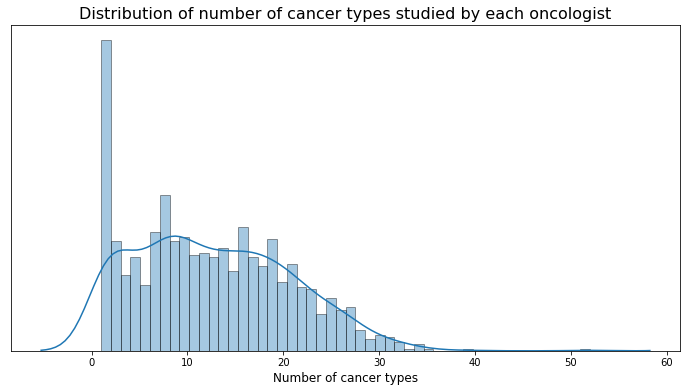

In [407]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(doctor2cancer_dict_counts,hist=True,bins=50,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of cancer types studied by each oncologist',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of cancer types',fontsize=12)

<a id='Part6_link'></a>
# 6. get pmid for doctor -- doctor2pmid_dict

In [431]:
doctor2pmid_dict2 = dict()

In [433]:
for doctor in doctor2pmid_dict:
    doctor2pmid_dict2[doctor]=list(oncologist_speciality_pmid_df.query('name=="{}"'.format(doctor)).pmid.unique())

In [434]:
len(doctor2pmid_dict2)

1153

In [436]:
pickle.dump(doctor2pmid_dict2, open(os.path.join(base_dir, "data/doctor2pmid_1153_dict3.pkl"), "wb"))